<div class="output_png output_subarea output_execute_result">
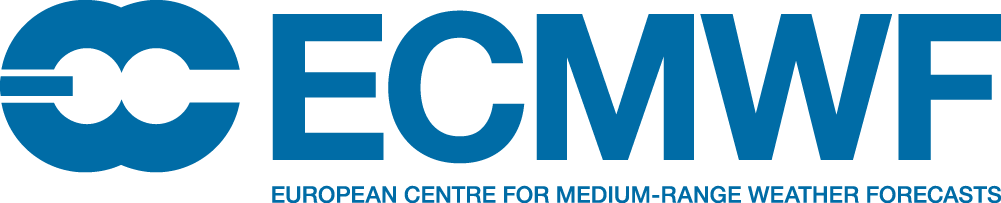
</div>

# 	Precipitation rate (Total/Large scale/Convective/Snowfall)

This notebook will provide you guidance how to explore ECMWF data to produce the map from the ECMWF open charts web product.  
The original product can be found on this link: https://charts.ecmwf.int/products/medium-rain-rate  


<div class="output_png output_subarea output_execute_result">
<center>
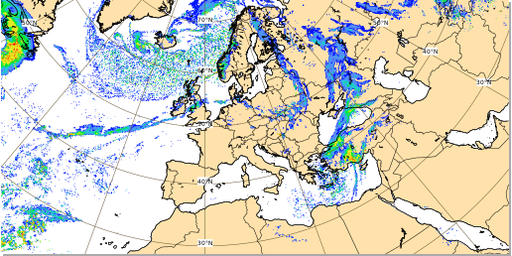</center>
</div>

Some ECMWF real-time products are governed by the [ECMWF Standard Licence Agreement](https://www.ecmwf.int/sites/default/files/ECMWF_Standard_Licence.pdf) and are not free or open. Access to these products depends on your use case. To find out which licence applies to you, please visit: [Use cases and licence conditions page](https://www.ecmwf.int/en/forecasts/accessing-forecasts/licences-available).  

To find out how to obtain the access to the ECMWF forecast data please visit our [Access page](https://www.ecmwf.int/en/forecasts/accessing-forecasts).

## Retrieve Data
This product takes in input one of these four parameters:

* [Total precipitation rate](https://codes.ecmwf.int/grib/param-db/260048)
* [Large scale rain rate](https://codes.ecmwf.int/grib/param-db/228219)
* [Convective rain rate](https://codes.ecmwf.int/grib/param-db/228218)
* [Convective snowfall rate water equivalent](https://codes.ecmwf.int/grib/param-db/228220)
* [Large scale snowfall rate water equivalent](https://codes.ecmwf.int/grib/param-db/228221)

In this example, we will use: 
- [**ecmwf-api-client**](https://pypi.org/project/ecmwf-api-client/) to download the data
- [**Metview**](https://metview.readthedocs.io/en/latest/) library to read, process and plot the data 

First we need to install them in the current Jupyter kernel:  
<div class="alert alert-block alert-info">
<b>Note:</b> If you are running the notebook on MyBinder or already have the libraries installed, go directly to importing the libraries.
</div>
<div class="alert alert-block alert-info">
<b>Note:</b> If you don't have these libraries installed, click on three dots below, uncomment the code and run the next cell.
</div>

In [1]:
#!pip install ecmwf-api-client metview metview-python

In [1]:
import metview as mv
from ecmwfapi import *
import requests

In [2]:
filename = "medium-rain-rate.grib"

If you already have the access to the ECMWF archived forecast data, you can use the next cell to download data from the [MARS archive](https://confluence.ecmwf.int/display/UDOC/MARS+user+documentation):

In [ ]:
server = ECMWFService("mars")
server.execute(
    {
    "class": "od",
    "date": "-1",
    "expver": "1",
    "levtype": "sfc",
    "param": "260048/228219/228218/228220/228221",
    "step": "12",
    "stream": "oper",
    "time": "00",
    "type": "fc",
    "grid": "0.25/0.25"
    },
    filename)

Alternatively we have prepared small sample dataset to explore

In [3]:
url = f"https://sites.ecmwf.int/repository/opencharts-sample-data/{filename}"
r = requests.get(url)
with open(filename, 'wb') as file:
    file.write(r.content)

## Reading and processing the data
Now we can use **Metview's read() function** to read the file.

In [4]:
data = mv.read(filename)

The **describe()** function will give us the overview of the dataset.  

In [5]:
data.describe()

parameter,typeOfLevel,level,date,time,step,number,paramId,class,stream,type,experimentVersionNumber
crr,surface,0,20250727,0,12,0,228218,od,oper,fc,0001
csfr,surface,0,20250727,0,12,0,228220,od,oper,fc,0001
lsrr,surface,0,20250727,0,12,0,228219,od,oper,fc,0001
lssfr,surface,0,20250727,0,12,0,228221,od,oper,fc,0001
tprate,surface,0,20250727,0,12,None,260048,od,oper,fc,0001


And an overview of one parameter, where we can see more information, such as units or type of level.

In [6]:
data.describe('tprate')

shortName,tprate
name,Total precipitation rate
paramId,260048
units,kg m**-2 s**-1
typeOfLevel,surface
level,0
date,20250727
time,0
step,12
number,None
class,od


We can use **ls()** function to list all the fields in the file we downloaded.

In [7]:
data.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
Message,,,,,,,,,,
0,ecmf,tprate,surface,0,20250727,0,12,fc,None,regular_ll
1,ecmf,lsrr,surface,0,20250727,0,12,fc,0,regular_ll
2,ecmf,crr,surface,0,20250727,0,12,fc,0,regular_ll
3,ecmf,csfr,surface,0,20250727,0,12,fc,0,regular_ll
4,ecmf,lssfr,surface,0,20250727,0,12,fc,0,regular_ll


The grib file contains all the parameters, and we will use the select() function to filter what we need.

In [8]:
tprate = data.select(shortName= 'tprate')
lsrr = data.select(shortName= 'lsrr')
crr = data.select(shortName= 'crr')
csfr = data.select(shortName= 'csfr')
lssfr = data.select(shortName= 'lssfr')

The data has units kg m-2 s-1, but we need to plot it in mm/hr.  
To convert to mm we need to multiply by 3600.

In [9]:
tprate = tprate * 3600
lsrr = lsrr * 3600
crr = crr * 3600

We can calculate total snowfall rate by adding the Large scale snowfall rate and Convective snowfall rate. In the end we also need to convert it too mm/hr.

In [10]:
sfr = (csfr + lssfr) * 3600

## Plotting the data
And finally, we can plot the data on the map.   
First we plot Total precipitation rate.

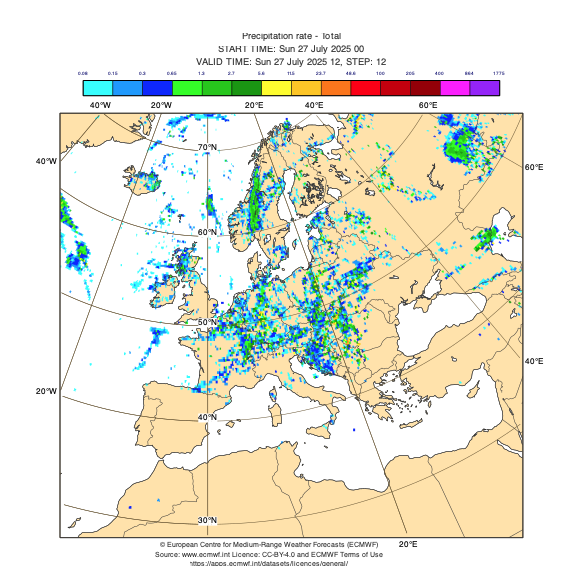

In [11]:
# define coastlines
coast = mv.mcoast(
    map_coastline_colour="charcoal",
    map_coastline_resolution="medium",
    map_coastline_land_shade="on",
    map_coastline_land_shade_colour="cream",
    map_coastline_sea_shade="off",
    map_boundaries="on",
    map_boundaries_colour= "charcoal",
    map_boundaries_thickness = 1,
    map_disputed_boundaries = "off",
    map_grid_colour="tan",
    map_label_height=0.35,
)

# define view
view = mv.geoview(
    area_mode="name",
    area_name="europe",
    coastlines=coast
)

#define styles
tprate_shade = mv.mcont(legend= "on",
                contour_automatics_settings = "style_name",
                contour_style_name = "sh_prate_radarlike_grided")

title = mv.mtext(
    text_lines=["Precipitation rate - Total", 
                "START TIME: <grib_info key='base-date' format='%a %d %B %Y %H'/> ",
                "VALID TIME: <grib_info key='valid-date' format='%a %d %B %Y %H'/>, STEP: <grib_info key='step' />"],
    text_font_size=0.4,
    text_colour         = 'charcoal')

ecmwf_text = mv.mtext(    
    text_lines          = ["© European Centre for Medium-Range Weather Forecasts (ECMWF)",
                           "Source: www.ecmwf.int Licence: CC-BY-4.0 and ECMWF Terms of Use",
                            "https://apps.ecmwf.int/datasets/licences/general/"],
    text_justification  = 'center',
    text_font_size      = 0.3,
    text_mode           = "positional",
    text_box_x_position = 6.,
    text_box_y_position = -0.2,
    text_box_x_length   = 8,
    text_box_y_length   = 2,
    text_colour         = 'charcoal')

# generate plot
mv.setoutput('jupyter', plot_widget=False)
mv.plot(view, tprate, tprate_shade, title, ecmwf_text)

Next we plot Large scale precipitation rate.

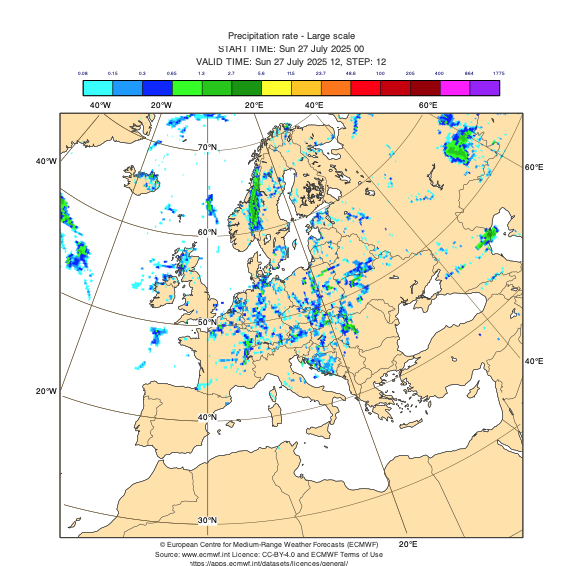

In [12]:
# define coastlines
coast = mv.mcoast(
    map_coastline_colour="charcoal",
    map_coastline_resolution="medium",
    map_coastline_land_shade="on",
    map_coastline_land_shade_colour="cream",
    map_coastline_sea_shade="off",
    map_boundaries="on",
    map_boundaries_colour= "charcoal",
    map_boundaries_thickness = 1,
    map_disputed_boundaries = "off",
    map_grid_colour="tan",
    map_label_height=0.35,
)

# define view
view = mv.geoview(
    area_mode="name",
    area_name="europe",
    coastlines=coast
)

#define styles
lsrr_shade = mv.mcont(legend= "on",
                contour_automatics_settings = "style_name",
                contour_style_name = "sh_prate_radarlike_grided")

title = mv.mtext(
    text_lines=["Precipitation rate - Large scale", 
                "START TIME: <grib_info key='base-date' format='%a %d %B %Y %H'/> ",
                "VALID TIME: <grib_info key='valid-date' format='%a %d %B %Y %H'/>, STEP: <grib_info key='step' />"],
    text_font_size=0.4,
    text_colour         = 'charcoal')

ecmwf_text = mv.mtext(    
    text_lines          = ["© European Centre for Medium-Range Weather Forecasts (ECMWF)",
                           "Source: www.ecmwf.int Licence: CC-BY-4.0 and ECMWF Terms of Use",
                            "https://apps.ecmwf.int/datasets/licences/general/"],
    text_justification  = 'center',
    text_font_size      = 0.3,
    text_mode           = "positional",
    text_box_x_position = 6.,
    text_box_y_position = -0.2,
    text_box_x_length   = 8,
    text_box_y_length   = 2,
    text_colour         = 'charcoal')

# generate plot
mv.setoutput('jupyter', plot_widget=False)
mv.plot(view, lsrr, lsrr_shade, title, ecmwf_text)

Next we plot Convective precipitation rate.

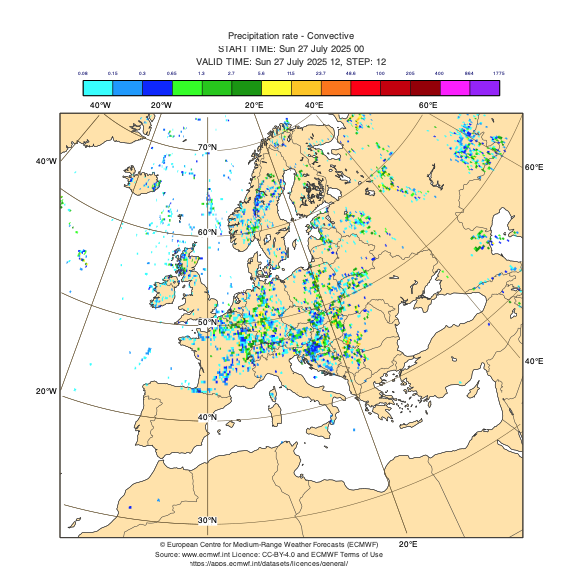

In [13]:
# define coastlines
coast = mv.mcoast(
    map_coastline_colour="charcoal",
    map_coastline_resolution="medium",
    map_coastline_land_shade="on",
    map_coastline_land_shade_colour="cream",
    map_coastline_sea_shade="off",
    map_boundaries="on",
    map_boundaries_colour= "charcoal",
    map_boundaries_thickness = 1,
    map_disputed_boundaries = "off",
    map_grid_colour="tan",
    map_label_height=0.35,
)

# define view
view = mv.geoview(
    area_mode="name",
    area_name="europe",
    coastlines=coast
)

#define styles
crr_shade = mv.mcont(legend= "on",
                contour_automatics_settings = "style_name",
                contour_style_name = "sh_prate_radarlike_grided")

title = mv.mtext(
    text_lines=["Precipitation rate - Convective", 
                "START TIME: <grib_info key='base-date' format='%a %d %B %Y %H'/> ",
                "VALID TIME: <grib_info key='valid-date' format='%a %d %B %Y %H'/>, STEP: <grib_info key='step' />"],
    text_font_size=0.4,
    text_colour         = 'charcoal')

ecmwf_text = mv.mtext(    
    text_lines          = ["© European Centre for Medium-Range Weather Forecasts (ECMWF)",
                           "Source: www.ecmwf.int Licence: CC-BY-4.0 and ECMWF Terms of Use",
                            "https://apps.ecmwf.int/datasets/licences/general/"],
    text_justification  = 'center',
    text_font_size      = 0.3,
    text_mode           = "positional",
    text_box_x_position = 6.,
    text_box_y_position = -0.2,
    text_box_x_length   = 8,
    text_box_y_length   = 2,
    text_colour         = 'charcoal')

# generate plot
mv.setoutput('jupyter', plot_widget=False)
mv.plot(view, crr, crr_shade, title, ecmwf_text)

And last we plot snowfall rate.

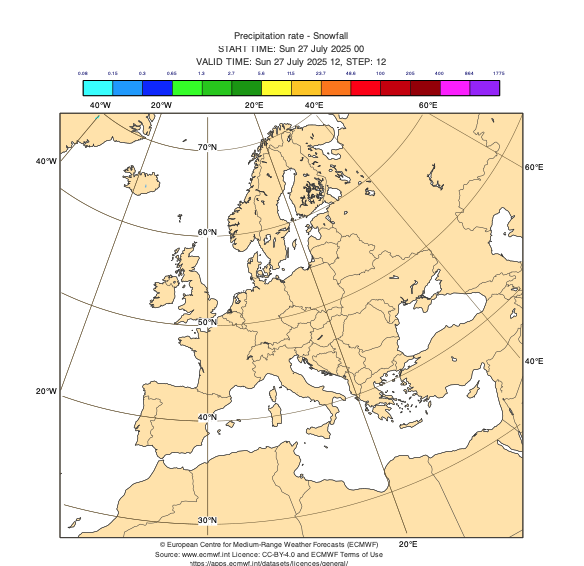

In [14]:
# define coastlines
coast = mv.mcoast(
    map_coastline_colour="charcoal",
    map_coastline_resolution="medium",
    map_coastline_land_shade="on",
    map_coastline_land_shade_colour="cream",
    map_coastline_sea_shade="off",
    map_boundaries="on",
    map_boundaries_colour= "charcoal",
    map_boundaries_thickness = 1,
    map_disputed_boundaries = "off",
    map_grid_colour="tan",
    map_label_height=0.35,
)

# define view
view = mv.geoview(
    area_mode="name",
    area_name="europe",
    coastlines=coast
)

#define styles
sfr_shade = mv.mcont(legend= "on",
                contour_automatics_settings = "style_name",
                contour_style_name = "sh_prate_radarlike_grided")

title = mv.mtext(
    text_lines=["Precipitation rate - Snowfall", 
                "START TIME: <grib_info key='base-date' format='%a %d %B %Y %H'/> ",
                "VALID TIME: <grib_info key='valid-date' format='%a %d %B %Y %H'/>, STEP: <grib_info key='step' />"],
    text_font_size=0.4,
    text_colour         = 'charcoal')

ecmwf_text = mv.mtext(    
    text_lines          = ["© European Centre for Medium-Range Weather Forecasts (ECMWF)",
                           "Source: www.ecmwf.int Licence: CC-BY-4.0 and ECMWF Terms of Use",
                            "https://apps.ecmwf.int/datasets/licences/general/"],
    text_justification  = 'center',
    text_font_size      = 0.3,
    text_mode           = "positional",
    text_box_x_position = 6.,
    text_box_y_position = -0.2,
    text_box_x_length   = 8,
    text_box_y_length   = 2,
    text_colour         = 'charcoal')

# generate plot
mv.setoutput('jupyter', plot_widget=False)
mv.plot(view, sfr, sfr_shade, title, ecmwf_text)

To generate the png files you can run the following four cells.

In [15]:
png = mv.png_output(
      output_name = "medium-rain-rate-tprate",   # specify relative or full path
      output_title = "medium-rain-rate-tprate",    # title used by a viewer
      output_width = 1000,                 # set width in pixels
)
mv.setoutput(png)
mv.plot(view, tprate, tprate_shade, title, ecmwf_text)

In [16]:
png = mv.png_output(
      output_name = "medium-rain-rate-lsrr",   # specify relative or full path
      output_title = "medium-rain-rate-lsrr",    # title used by a viewer
      output_width = 1000,                 # set width in pixels
)
mv.setoutput(png)
mv.plot(view, lsrr, lsrr_shade, title, ecmwf_text)

In [17]:
png = mv.png_output(
      output_name = "medium-rain-rate-crr",   # specify relative or full path
      output_title = "medium-rain-rate-crr",    # title used by a viewer
      output_width = 1000,                 # set width in pixels
)
mv.setoutput(png)
mv.plot(view, crr, crr_shade, title, ecmwf_text)

In [18]:
png = mv.png_output(
      output_name = "medium-rain-rate-sfr",   # specify relative or full path
      output_title = "medium-rain-rate-sfr",    # title used by a viewer
      output_width = 1000,                 # set width in pixels
)
mv.setoutput(png)
mv.plot(view, sfr, sfr_shade, title, ecmwf_text)

Note that plot produced using this dataset will slightly differ from one from Open Charts. This is due to different resolution of the data.  
The data used here is on 0.25x0.25 resolution, while charts show the data on original grid of the model.